#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем необходимые библиотеки, модели, метрики:

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

Рассмотрим данные:

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [6]:
data.duplicated().sum()

26415

In [7]:
data.isna().sum()

num_orders    0
dtype: int64

In [8]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Дубликаты и пропуски отсутствуют. Посмотрим на соблюдение последовательности дат и отсортируем индексы:

In [9]:
print(data.index.is_monotonic)

True


In [10]:
data = data.sort_index()

Проведем ресемплинг данных по 1 часу:

In [11]:
data = data.resample('1H').sum()

**Вывод:**

1. Данные расмотрены, дубликаты и пропуски отсутствуют;
2. Проведена проверка данных на соблюдение хронологии, выполнен ресемплинг с 10 минут на 1 час;
3. Данные представлены за март-август 2018 года.


<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Ресемплинг был сделан верно.
</div>

## Анализ

Построим график временного ряда:

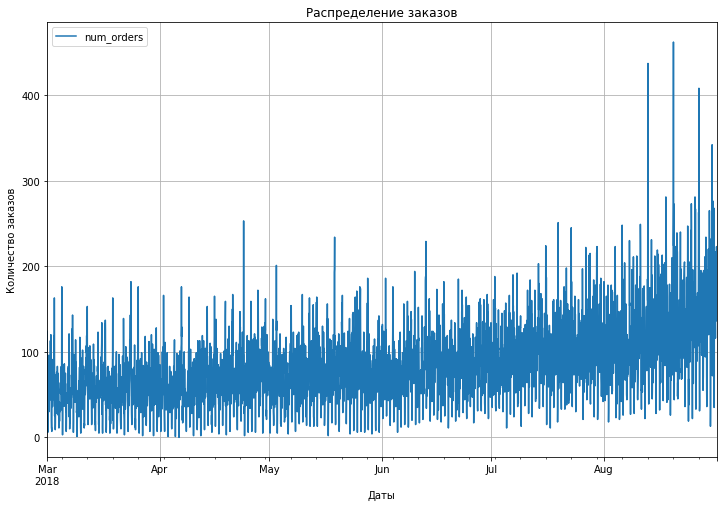

In [12]:
data.plot(figsize=(12,8))
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.title('Распределение заказов')
plt.grid()
plt.show()

Проверим стационарность временного ряда. Для этого вычислим разности временного ряда с помощью метода shift(). Визуализируем:

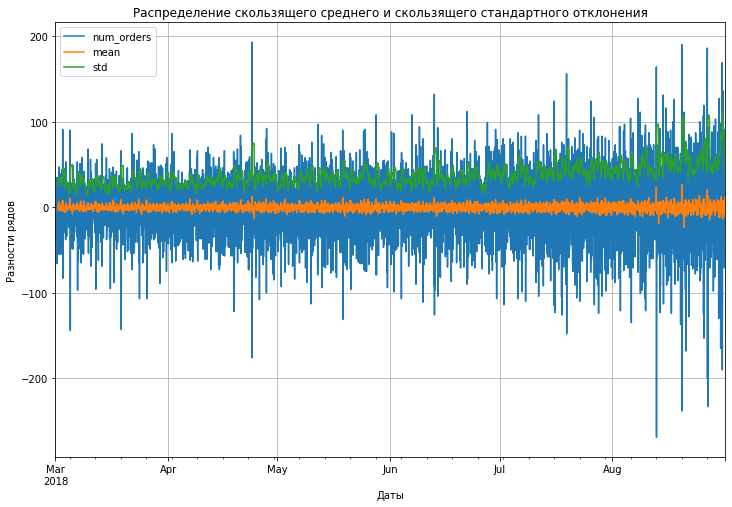

In [13]:
data_converted = data - data.shift()
data_converted['mean'] = data_converted['num_orders'].rolling(15).mean()
data_converted['std'] = data_converted['num_orders'].rolling(15).std()
data_converted.plot(figsize=(12,8))
plt.xlabel('Даты')
plt.ylabel('Разности рядов')
plt.title('Распределение скользящего среднего и скользящего стандартного отклонения')
plt.grid()
plt.show()

Можно заключить, что ряд достаточно стационарен, так как среднее и стандартное отклонение не меняются сильно.

Декомпозируем временной ряд на тренд, сезонную компоненту и остатки, также визуализируем:

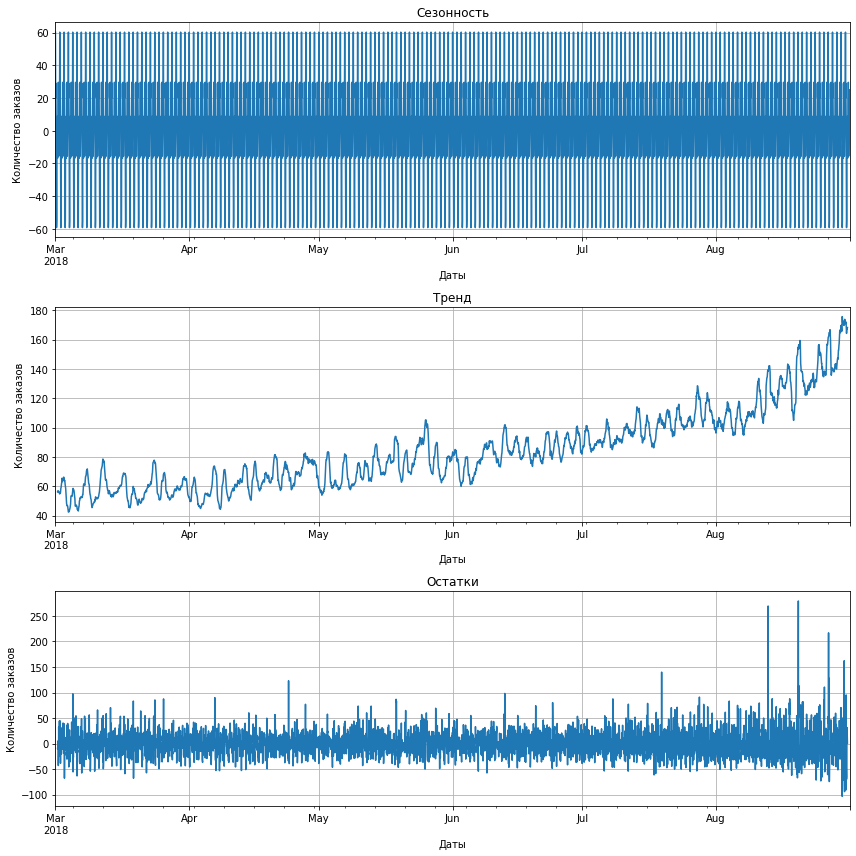

In [14]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.grid()

plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.grid()

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.grid()

plt.tight_layout()

Уточним график сезонности. Возьмем полностью июль и отдельно одну неделю, а также 2 суток:

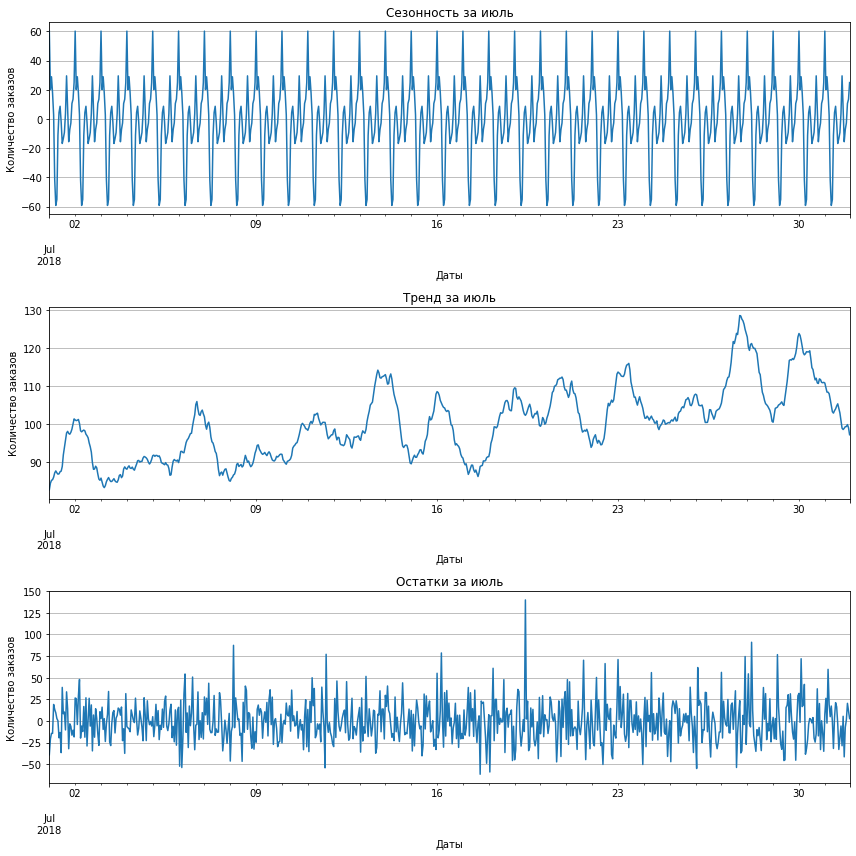

In [15]:
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.seasonal['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.title('Сезонность за июль')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.grid()

plt.subplot(312)
decomposed.trend['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.title('Тренд за июль')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.grid()

plt.subplot(313)
decomposed.resid['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.title('Остатки за июль')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.grid()

plt.tight_layout()

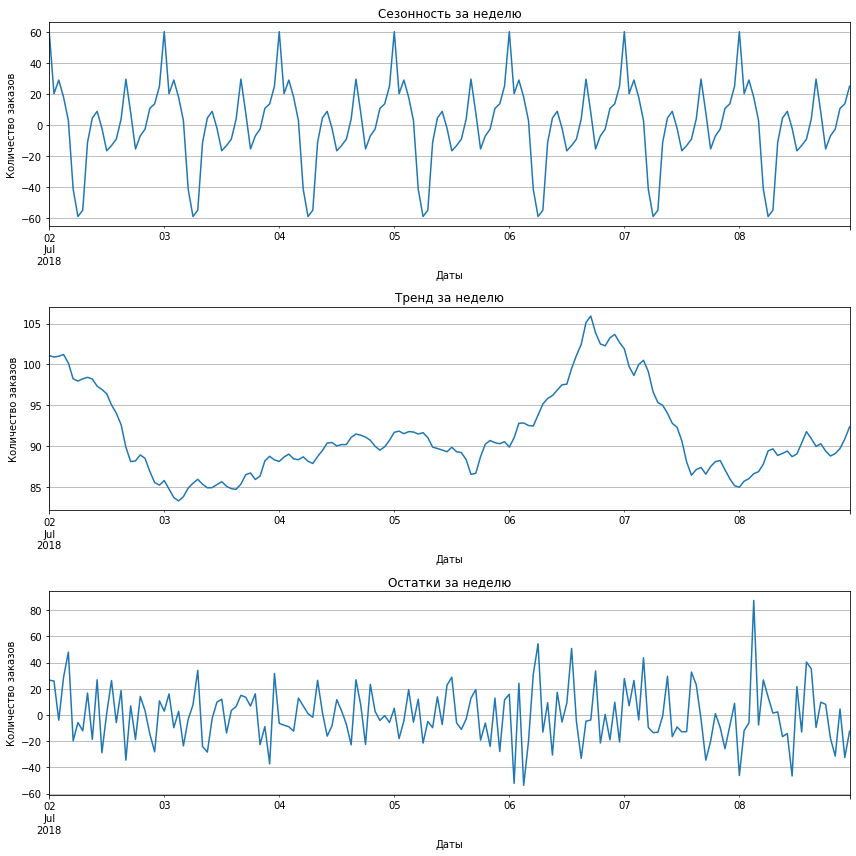

In [16]:
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.seasonal['2018-07-02':'2018-07-08'].plot(ax=plt.gca())
plt.title('Сезонность за неделю')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.grid()

plt.subplot(312)
decomposed.trend['2018-07-02':'2018-07-08'].plot(ax=plt.gca())
plt.title('Тренд за неделю')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.grid()

plt.subplot(313)
decomposed.resid['2018-07-02':'2018-07-08'].plot(ax=plt.gca())
plt.title('Остатки за неделю')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.grid()

plt.tight_layout()

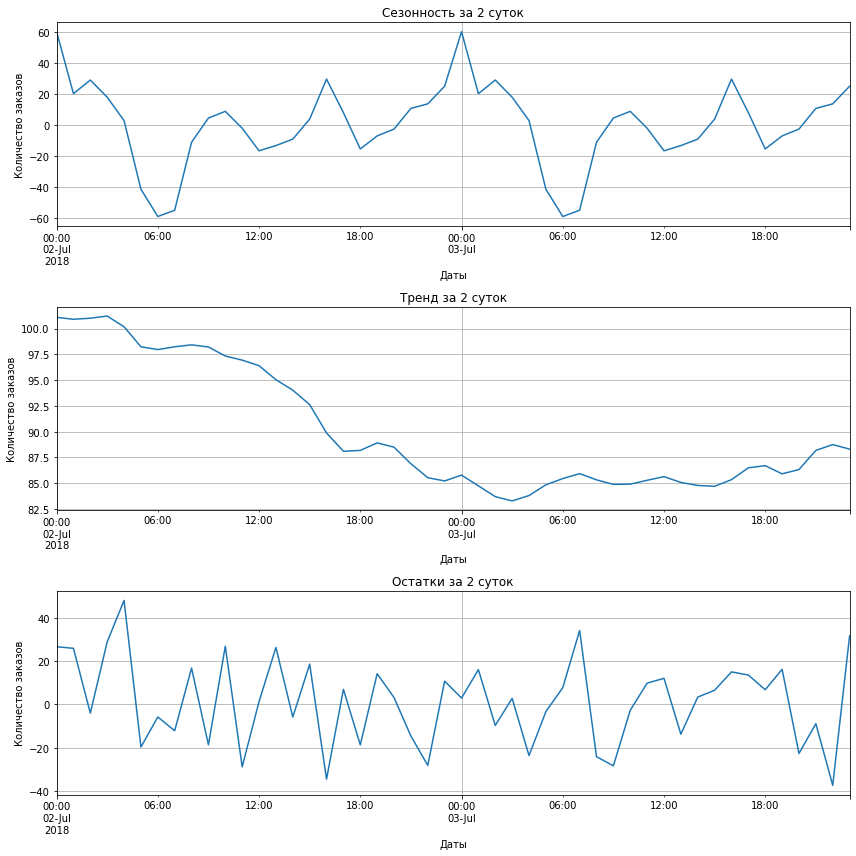

In [17]:
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.seasonal['2018-07-02':'2018-07-03'].plot(ax=plt.gca())
plt.title('Сезонность за 2 суток')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.grid()

plt.subplot(312)
decomposed.trend['2018-07-02':'2018-07-03'].plot(ax=plt.gca())
plt.title('Тренд за 2 суток')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.grid()

plt.subplot(313)
decomposed.resid['2018-07-02':'2018-07-03'].plot(ax=plt.gca())
plt.title('Остатки за 2 суток')
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.grid()

plt.tight_layout()

**Итого:** Как и следовало ожидать, тренд отражает увеличение количества поездок в летний период времени. Можно предположить, что это связано с сезоном отпусков, увеличением летних развлечений и др. Пик поездок в течение недели приходится на пятницу и субботу, а в будние дни (2 и 3 июля - понедельник и вторник) пик раннее утро.

Поскольку у нас данные только за полгода, то есть нет возможности для сравнения аналогичных периодов, то по сезонности за весь период не можем прослежить.

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале!
</div>

**Подготовим данные для обучения.**

Напишем функцию для обогащения данных новыми признаками. На вход функция принимает data, максимальный размер отставания max_lag и размер окна для вычисления значений скользящего среднего rolling_mean_size.


In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.dayofweek
   
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [19]:
make_features(data, 20, 20)
print(data.head())

                     num_orders  month  day  dayofweek  hour  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124      3    1          3     3    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3     3  124.0    NaN   
2018-03-01 02:00:00          71      3    1          3     3   85.0  124.0   
2018-03-01 03:00:00          66      3    1          3     3   71.0   85.0   
2018-03-01 04:00:00          43      3    1          3     3   66.0   71.0   

                     lag_3  lag_4  lag_5  ...  lag_12  lag_13  lag_14  lag_15  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00  124.0    NaN    NaN  ...   

Удалим пропуски.

In [20]:
data.dropna(inplace=True)

In [21]:
data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 20:00:00,61,3,1,3,3,45.0,73.0,44.0,43.0,66.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,53.30
2018-03-01 21:00:00,66,3,1,3,3,61.0,45.0,73.0,44.0,43.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,50.15
2018-03-01 22:00:00,113,3,1,3,3,66.0,61.0,45.0,73.0,44.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,49.20
2018-03-01 23:00:00,58,3,1,3,3,113.0,66.0,61.0,45.0,73.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,51.30
2018-03-02 00:00:00,90,3,2,4,4,58.0,113.0,66.0,61.0,45.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,50.90


**Вывод:**

1. Построили и изучили графики временного ряда по следующим периодам: весь предоставленный период (март-август), месяц (июль), неделя и 2 суток;
2. Отметили общий тренд к росту заказов за весь период, наблюдается сезонность по дням недели, а также времени суток;
3. Проверили также на стационарность временного ряда, созданы дополнительные признаки, подготовили данные к созданию моделей.


## Обучение

Разобъем данные на три выборки: тестовая, валидационная и обучающая. Выделим признаки:

In [22]:
features = data.drop(['num_orders'], axis = 1)
target = data['num_orders']

In [23]:
features_df, features_test, target_df, target_test = train_test_split(
    features, target, shuffle=False, test_size=.1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_df, target_df, shuffle=False, test_size=.2)

<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано корректно. А зачем тут random_state?
</div>

**Линейная регрессия:**

In [24]:
lr_model = LinearRegression()

In [25]:
%%time

lr_model.fit(features_train, target_train)
predictions_valid = lr_model.predict(features_valid)

print('RMSE модели равно:', mean_squared_error(target_valid, predictions_valid)**0.5)

RMSE модели равно: 37.604953786396614
CPU times: user 13.2 ms, sys: 75.8 ms, total: 89 ms
Wall time: 37.2 ms


**Дерево решений:**

Также создадим цикл, с помощью которого подберем дерево с минимальным RMSE:

In [26]:
%%time

best_result = 48
depth = 0
depths = []
results = []

for depth in range(1, 30, 3):
    dt_model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    dt_model.fit(features_train, target_train)
    predictions_valid = dt_model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** .5
    depths.append(depth)
    results.append(result)
                
    if result < best_result:
        best_depth = depth
        best_result = result

        
print('RMSE модели равно:', best_result, '   Глубина:', best_depth)   

RMSE модели равно: 43.94970634840981    Глубина: 10
CPU times: user 505 ms, sys: 281 µs, total: 505 ms
Wall time: 513 ms


**Случайный лес:**

In [27]:
%%time

best_result = 48
depth = 0
depths = []
results = []

for depth in range(3, 20, 3):
    rf_model = RandomForestRegressor(random_state=12345, max_depth = depth)
    rf_model.fit(features_train, target_train)
    predictions_valid = rf_model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** .5
    depths.append(depth)
    results.append(result)
              
    if result < best_result:
        best_depth = depth
        best_result = result

        
print('RMSE модели равно:', best_result, '   Глубина:', best_depth)   

RMSE модели равно: 37.46045503789755    Глубина: 15
CPU times: user 16.2 s, sys: 43.2 ms, total: 16.2 s
Wall time: 16.2 s


Лучшее количество деревьев:

In [28]:
%%time

best_result = 48
est = 0
ests = []
results = []

for est in [100, 500, 1000]:
    rf_model = RandomForestRegressor(random_state=12345, max_depth = 15)
    rf_model.fit(features_train, target_train)
    predictions_valid = rf_model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** .5
    ests.append(est)
    results.append(result)
              
    if result < best_result:
        best_est = est
        best_result = result

        
print('RMSE модели равно:', best_result, '   Количество деревьев:', best_est) 

RMSE модели равно: 37.46045503789755    Количество деревьев: 100
CPU times: user 11.1 s, sys: 28.8 ms, total: 11.1 s
Wall time: 11.2 s


In [29]:
%%time

rf_model = RandomForestRegressor(random_state=12345, max_depth=15, n_estimators=100)
rf_model.fit(features_train, target_train)
rf_predictions_valid = rf_model.predict(features_valid)
print('RMSE модели равно:', mean_squared_error(target_valid, rf_predictions_valid) ** .5)

RMSE модели равно: 37.46045503789755
CPU times: user 3.71 s, sys: 8.19 ms, total: 3.72 s
Wall time: 3.73 s


**LightGBM:**

In [30]:
time_split = TimeSeriesSplit(n_splits=5)
parameters = {'n_estimators': [100, 500, 1000],
              'num_leaves': [n for n in range(20, 300, 20)]}

In [ ]:
%%time

lg_model = lgb.LGBMRegressor(random_state=12345)
gs_lg = GridSearchCV(estimator=lg_model,
                          param_grid=parameters,
                          scoring='neg_root_mean_squared_error',
                          cv=time_split,
                          verbose=3)

gs_lg.fit(features_train, target_train)
display(gs_lg.best_params_)
display(gs_lg.best_score_*-1)

In [32]:
lg_model = lgb.LGBMRegressor(random_state=12345, n_estimators=100, num_leaves=20)
lg_model.fit(features_train, target_train)
lg_predictions_valid = lg_model.predict(features_valid)
print('RMSE модели равно:', mean_squared_error(target_valid, lg_predictions_valid) ** .5)

RMSE модели равно: 36.63109353041167


**CatBoost:**

In [33]:
parameters = [{'learning_rate':[0.1, 0.2, 0.3],
                'random_state':[12345],
                'verbose':[False]}]

In [ ]:
%%time

cb_model = CatBoostRegressor()
gs_cb = GridSearchCV(estimator= cb_model,
                          param_grid=parameters,
                          scoring='neg_root_mean_squared_error',
                          cv=time_split)

gs_cb.fit(features_train, target_train)
display(gs_cb.best_params_)
display(gs_cb.best_score_*-1)

In [35]:
cb_model = CatBoostRegressor(learning_rate=0.1, random_state=12345, verbose= False)
cb_model.fit(features_train, target_train)
cb_predictions_valid = cb_model.predict(features_valid)
print('RMSE модели равно:', mean_squared_error(target_valid, cb_predictions_valid) ** .5)

RMSE модели равно: 35.158925408035685


**Вывод:**

1. Лучшие показатель у Catboost RMSE = 35.15;
2.  RMSE у LightGBM равен 36.6; У cлучайного леса RMSE = 37.5, линейной регрессии RMSE = 37.6, дерева решений RMSE = 43.9;
3. Тестирование будет проводиться на CatBoost. 

## Тестирование

Проведем итоговое тестирование, обучив модели на объедененной тренировочной и тестовой выборках (features_df, target_df). Также визуализируем:

In [37]:
%%time

model = CatBoostRegressor(learning_rate=0.1, random_state=12345, verbose= False)
model.fit(features_df, target_df)
predictions_test= model.predict(features_test)
print('RMSE на тестовой выборке: ', mean_squared_error(target_test, predictions_test) ** .5)

RMSE на тестовой выборке:  45.98171705725536
CPU times: user 5.02 s, sys: 70.8 ms, total: 5.09 s
Wall time: 5.8 s


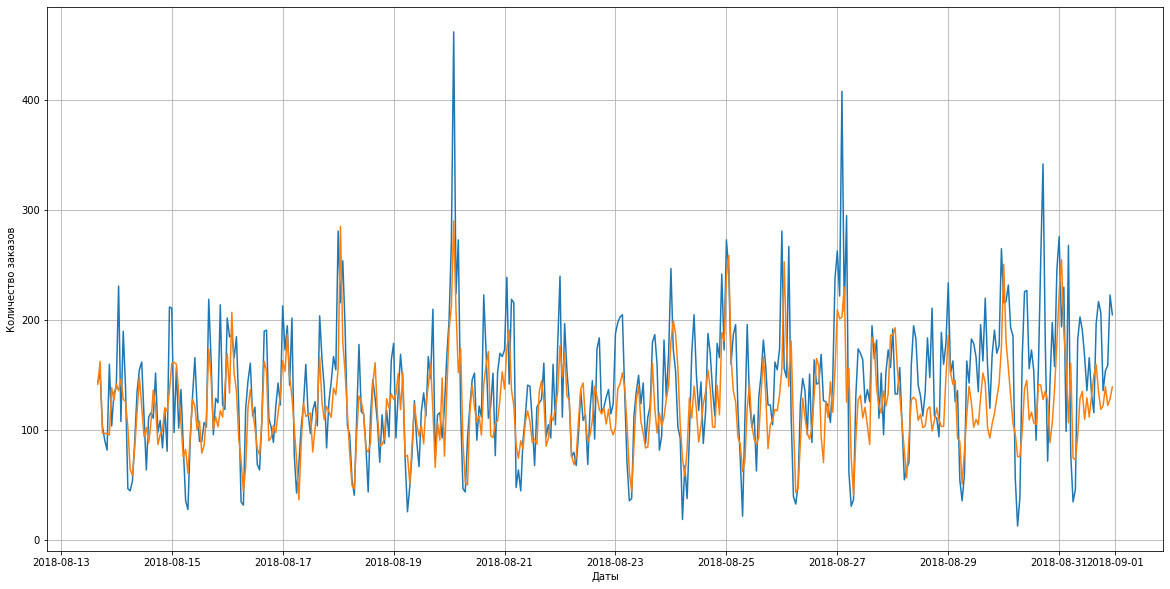

In [41]:
predictions_test = pd.Series(predictions_test, index=target_test.index)
plt.figure(figsize=(20,10))
plt.xlabel('Даты')
plt.ylabel('Количество заказов')
plt.plot(target_test, label='Исходная выборка')
plt.plot(predictions_test, label='Предсказания')
plt.grid()

plt.show()

На графике вижно, что модель сильно ошибается в пиковые моменты, в остальных - хорошо справляется.

**Вывод:**

1. В ходе исследования были загружены изучены данные, проводена их сортировка, ресемплинг по часам, а также созданы дополнительные признаки;
2. Для исследования данные были разбиты на три выборки;
3. Для обучения были использованы модели: линейная регрессия, случайный лес, дерево решений, LightGBM и Catboost. Лучшие показатели RMSE был у Catboost;
4. Модель Catboost на итоговой тестовой выборке показала хороший результат RMSE = 45.98, что ниже требуемого 48;
5. Для дальнейшего использования рекомендована модель Catboost.

